In [ ]:
pip install requests beautifulsoup4 robustbase


In [1]:
import requests
from bs4 import BeautifulSoup
from sklearn.covariance import MinCovDet
from scipy.stats import chi2
import numpy as np
from sklearn.preprocessing import MinMaxScaler



In [3]:
import json
import pandas as pd
import re

df = pd.read_csv("B:/tut-pricing-model\Makeup Essentials Scrape - Copy of Sheet1.csv", encoding="utf-8")


df = df.dropna(subset=["Price"])
import time


# Define the function to scrape the brand name
def scrape_brand_name(session, url):
    try:
        if not url or not url.startswith("http"):  # Validate URL
            return None

        # Send a GET request to the URL using the session
        response = session.get(url, timeout=10)
        response.raise_for_status()  # Raise an error for HTTP issues

        # Parse the page content with BeautifulSoup
        soup = BeautifulSoup(response.content, "html.parser")

        # Adjust this selector based on the actual structure of the webpage
        brand_tag = soup.find("tr", class_="a-spacing-small po-brand")
        if brand_tag:
            td_tag = brand_tag.find("td", class_="a-span9")
            if td_tag:
                span_tag = td_tag.find("span", class_="a-size-base po-break-word")
                if span_tag:
                    return span_tag.get_text(strip=True)

        # Return None if the brand name is not found
        return None

    except requests.exceptions.RequestException as e:
        print(f"Network error scraping {url}: {e}")
        return None
    except Exception as e:
        print(f"Error scraping {url}: {e}")
        return None

# Load the JSON file

"""
# Ensure the 'link' column exists and is valid
if "link" in df.columns:
    # Create a requests session
    with requests.Session() as session:
        # Set a User-Agent header to mimic a browser (optional but recommended)
        session.headers.update({
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36"
        })

        # Apply the scraping function to the 'link' column
        brand_names = []
        for idx, url in enumerate(df["link"]):
            print(f"Scraping {idx + 1}/{len(df)}: {url}")
            brand_name = scrape_brand_name(session, url)
            brand_names.append(brand_name)

            # Throttle requests to avoid getting blocked
            time.sleep(2)

        # Add the scraped brand names to the DataFrame
        df["brand_name"] = brand_names"""




def extract_volume(title_str):
    # Check for "ml" first to avoid misidentification
    match_ml = re.search(r'(\d+(?:\.\d+)?)\s*ml', title_str, re.IGNORECASE)
    if match_ml:
        return float(match_ml.group(1))  # Prioritize ml if present
    else:
    # Check for "oz" (fluid ounces)
      match_oz = re.search(r'(\d+(?:\.\d+)?)\s*(?:fl\.?\s*oz|oz|fluid ounces?)', title_str, re.IGNORECASE)
      if match_oz:
         return float(match_oz.group(1)) * 29.5735  # Convert oz to ml

    # If no match, return None
    return None

# Apply the function to the DataFrame
df["volume"] = df["Product Name"].apply(extract_volume)

def remove_duplicates_by_name_and_price(df):
    # Sort the DataFrame to keep the first occurrence of each duplicate
    df = df.sort_values(by=["Product Name", "Price"])

    # Drop duplicates based on 'name' and 'price_numeric'
    df = df.drop_duplicates(subset=["Product Name", "Price"], keep="first")

    return df

# Apply the duplicate removal function to the DataFrame
df = remove_duplicates_by_name_and_price(df)



<>:5: SyntaxWarning: invalid escape sequence '\M'
<>:5: SyntaxWarning: invalid escape sequence '\M'
C:\Users\Basmala Kamal\AppData\Local\Temp\ipykernel_13796\275069771.py:5: SyntaxWarning: invalid escape sequence '\M'
  df = pd.read_csv("B:/tut-pricing-model\Makeup Essentials Scrape - Copy of Sheet1.csv", encoding="utf-8")


In [4]:
print(df["Product type"].unique())


['Foundation ' 'Highlighter ' 'Lipstick' 'Tint' 'Concealer']


In [5]:
print(df["Product type"].value_counts(dropna=False))


Product type
Lipstick        1557
Foundation      1038
Concealer        554
Highlighter      306
Tint             281
Name: count, dtype: int64


In [6]:
df_foundation = df[df["Product type"].str.strip().str.lower() == "foundation"]
print(df_foundation[["Product Name", "volume", "Price"]])
print(df_foundation.shape)


                                           Product Name  volume    Price
433   2 x Bourjois Healthy Mix Anti Fatigue Foundati...    30.0    52.99
913   3 x Max Factor Lasting Performance Weightless ...     NaN   232.24
3473  ANASTASIA BEVERLY HILLS Impeccable Blurring Se...     NaN   240.00
3484        ANASTASIA BEVERLY HILLS Luminous Foundation     NaN   220.00
1815  AVON AVON Power Stay 24 Hour Longwear Foundati...     NaN       65
...                                                 ...     ...      ...
887   tarte Amazonian clay 16-hour full coverage fou...     NaN   204.78
886   tarte Amazonian clay 16-hour full coverage fou...     NaN   204.78
885   tarte Amazonian clay 16-hour full coverage fou...     NaN   204.78
1856        theBalm Balmshelter Tinted Moisturizer Dark     NaN      224
583   كريم أساس مرطب بزبده الشيا والافوكادو e.l.f. S...     NaN       75

[1038 rows x 3 columns]
(1038, 8)


In [7]:
def is_multi_item(title):
    title = title.lower()

    # Case 1: 'Set' and 'Pieces'
    if "set" in title and "pieces" in title or "bundle" in title or "pack" in title:
        return True

    # Case 2: '2-pack', 'two-pack', '2 bottles', 'two bottles'
    if re.search(r'(2-pack|two-pack|2 bottles|two bottles|two items|two)', title, re.IGNORECASE):
        return True

    # Case 3: '3 bottles', '4 pack', '5 count', etc.
    if re.search(r'\b\d+\s*(?:bottles|packs?|count)\b', title, re.IGNORECASE):
        return True

    return False

# Create a mask for sets
mask_sets = df_foundation["Product Name"].apply(is_multi_item)

# Split the DataFrame
sets_df_foundation = df_foundation[mask_sets].copy()
df_foundation = df_foundation[~mask_sets].copy()

# Optional: Reset index if needed
sets_df_foundation.reset_index(drop=True, inplace=True)
df_foundation.reset_index(drop=True, inplace=True)

In [8]:
df_foundation["Price"] = df_foundation["Price"].replace(r"[^\d.]", "", regex=True).astype(float)


In [ ]:
"""df_foundation["volume_per_price"] = np.where(
    (df_foundation["volume"].notna()) &
    (df_foundation["Price"].notna()) &
    (df_foundation["Price"] > 0),
    df_foundation["volume"] / df_foundation["Price"],
    np.nan
)
"""

In [9]:
print(df_foundation["Price"].describe())


count     995.000000
mean      128.999950
std       110.779592
min        11.300000
25%        60.475000
50%        89.950000
75%       184.990000
max      1634.000000
Name: Price, dtype: float64


In [ ]:
#print(df_foundation["volume_per_price"].describe())


count    363.000000
mean       0.660438
std        2.955664
min        0.018360
25%        0.185977
50%        0.329960
75%        0.500209
max       43.063342
Name: volume_per_price, dtype: float64


In [10]:
# Clip the top 1% to focus on the bulk of data
clip_val = df_foundation["Price"]

plt.figure(figsize=(10, 6))
sns.histplot(df_foundation[df_foundation["Price"] <= clip_val]["Price"], bins=30, kde=True)
plt.title("Volume per Price (Clipped at 99th Percentile)")
plt.xlabel("Volume per Price")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


NameError: name 'plt' is not defined

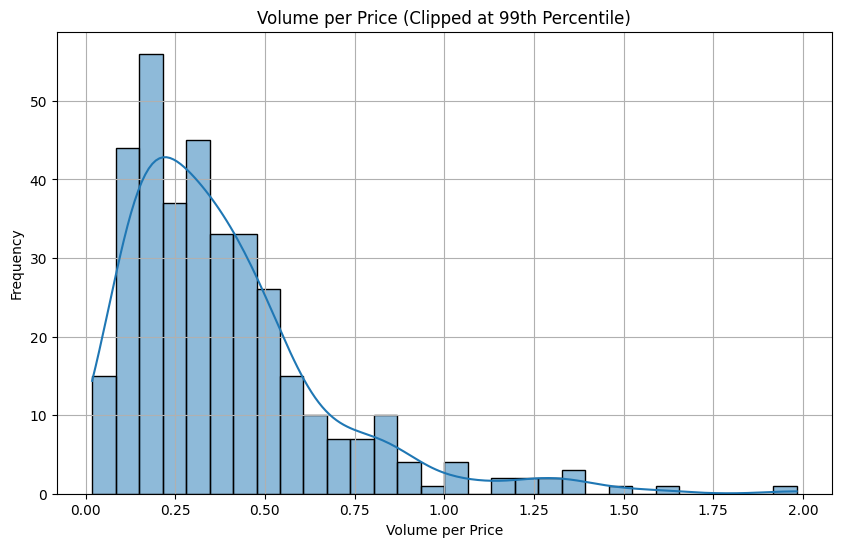

In [ ]:
"""# Clip the top 1% to focus on the bulk of data
clip_val = df_foundation["volume_per_price"].quantile(0.99)

plt.figure(figsize=(10, 6))
sns.histplot(df_foundation[df_foundation["volume_per_price"] <= clip_val]["volume_per_price"], bins=30, kde=True)
plt.title("Volume per Price (Clipped at 99th Percentile)")
plt.xlabel("Volume per Price")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()
"""

In [11]:
products_to_remove = [
    "NARS Sheer Glow Med/Dark 3.6 Belem Foundation 30ml",
    "Bourjois Healthy Mix Anti-Fatigue BB Cream (02 Medium - 30ml)"
]

df_foundation = df_foundation[~df_foundation["Product Name"].isin(products_to_remove)]


In [12]:
df_cleaned = df_foundation.dropna(subset=["Product Name", "Price"])
df_cleaned.shape

(993, 8)

In [ ]:
"""import numpy as np
from sklearn.preprocessing import StandardScaler

# Apply log transformation
df_cleaned["price_log"] = np.log1p(df_cleaned["volume_per_price"])

# Then standard scale
scaler = StandardScaler()
df_cleaned["price_scaled"] = scaler.fit_transform(df_cleaned[["price_log"]])"""

<ipython-input-100-18c0a0f0c5eb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["price_log"] = np.log1p(df_cleaned["volume_per_price"])
<ipython-input-100-18c0a0f0c5eb>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["price_scaled"] = scaler.fit_transform(df_cleaned[["price_log"]])


<ipython-input-101-3b9f36f77b8b>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[cluster_col] = kmeans.labels_
<ipython-input-101-3b9f36f77b8b>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[cluster_col] = kmeans.labels_
<ipython-input-101-3b9f36f77b8b>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

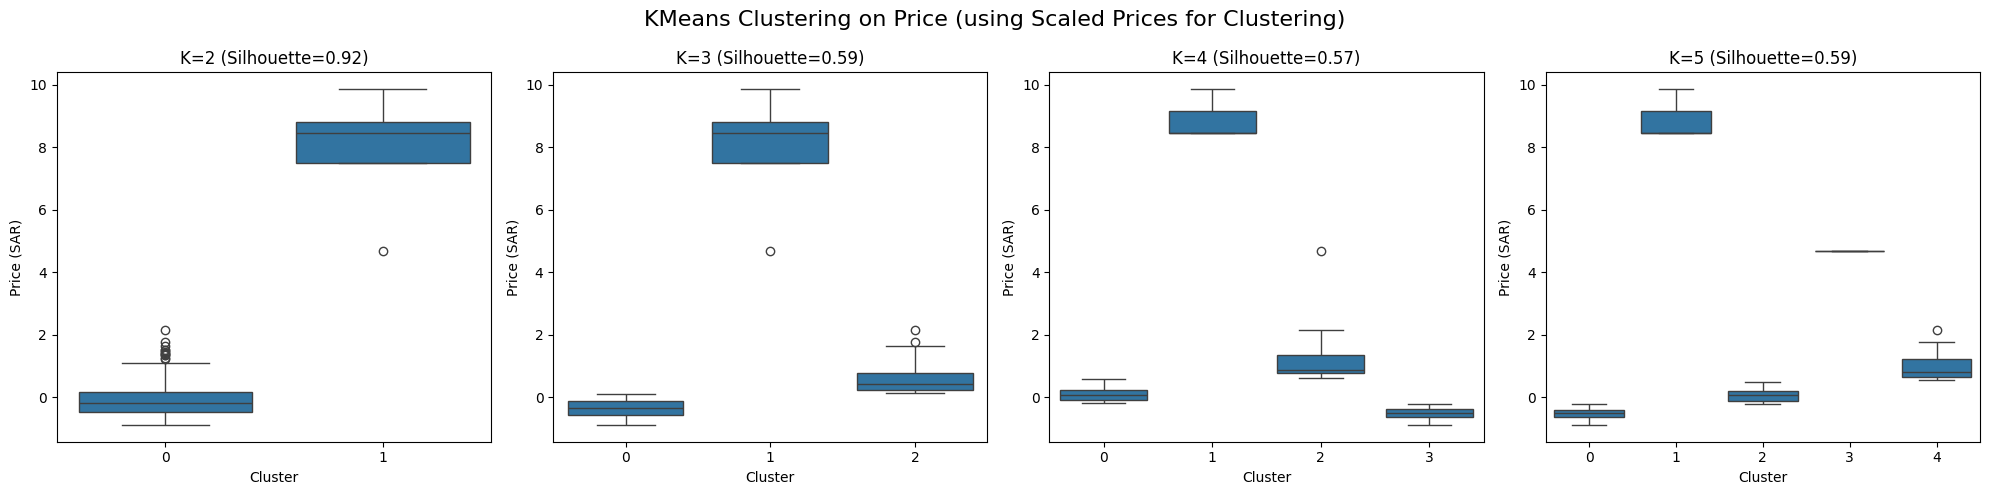

In [ ]:
"""from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


# 2. Feature for clustering
X_price = df_cleaned[["price_scaled"]].values

# 3. Plot setup
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# 4. Try multiple cluster counts
for idx, k in enumerate([2, 3, 4, 5]):
    if len(df_cleaned) < k:
        print(f"Skipping k={k} due to insufficient data.")
        continue

    # Fit KMeans
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(X_price)

    # Add cluster labels to DataFrame
    cluster_col = f"cluster_k{k}"
    df_cleaned[cluster_col] = kmeans.labels_

    # Silhouette score
    if len(set(kmeans.labels_)) > 1:
        sil_score = silhouette_score(X_price, kmeans.labels_)
    else:
        sil_score = np.nan

    # Boxplot using raw prices, grouped by cluster
    sns.boxplot(
        x=cluster_col,
        y="price_scaled",  # Show real prices
        data=df_cleaned,
        ax=axes[idx]
    )
    axes[idx].set_title(f"K={k} (Silhouette={sil_score:.2f})")
    axes[idx].set_xlabel("Cluster")
    axes[idx].set_ylabel("Price (SAR)")

# Final plot formatting
plt.suptitle("KMeans Clustering on Price (using Scaled Prices for Clustering)", fontsize=16)
plt.tight_layout()
plt.show()
"""

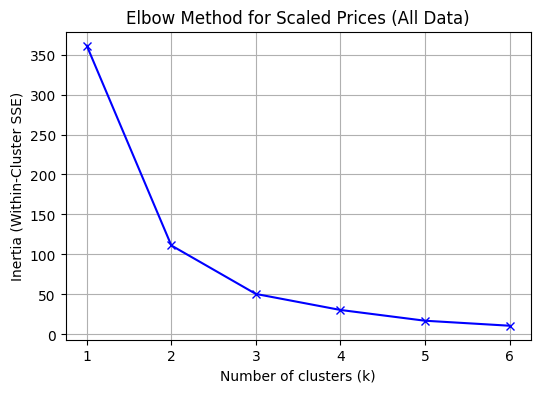

In [ ]:
"""from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Extract scaled price for clustering
X_price = df_cleaned[["price_scaled"]].values

# Elbow Method: Try k from 2 to 5
distortions = []
K_range = range(1, 7)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(X_price)
    distortions.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(6, 4))
plt.plot(K_range, distortions, 'bx-')
plt.title('Elbow Method for Scaled Prices (All Data)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-Cluster SSE)')
plt.xticks(K_range)
plt.grid(True)
plt.show()
"""

In [ ]:
"""import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# 1. Extract price_scaled values for clustering
X_price = df_cleaned[["price_scaled"]].values

# 2. Run KMeans with k=3
k = 2
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(X_price)

# 3. Assign cluster labels back to df_cleaned
df_cleaned = df_cleaned.copy()  # optional: avoid modifying original
df_cleaned["final_cluster"] = kmeans.labels_

# 4. Show actual price statistics per cluster
summary = (
    df_cleaned
    .groupby("final_cluster")["Price"]
    .agg(["count", "mean", "min", "max"])
    .sort_index()
)

print("Cluster Summary Based on Actual Prices (SAR):")
print(summary)
"""

Cluster Summary Based on Actual Prices (SAR):
               count        mean    min    max
final_cluster                                 
0                357  111.234342  13.50  505.0
1                  4  102.397500  29.53  225.0


In [13]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Apply log transformation
df_cleaned["price_log"] = np.log1p(df_cleaned["Price"])

# Then standard scale
scaler = StandardScaler()
df_cleaned["price_scaled"] = scaler.fit_transform(df_cleaned[["price_log"]])

C:\Users\Basmala Kamal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Basmala Kamal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.1008.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 

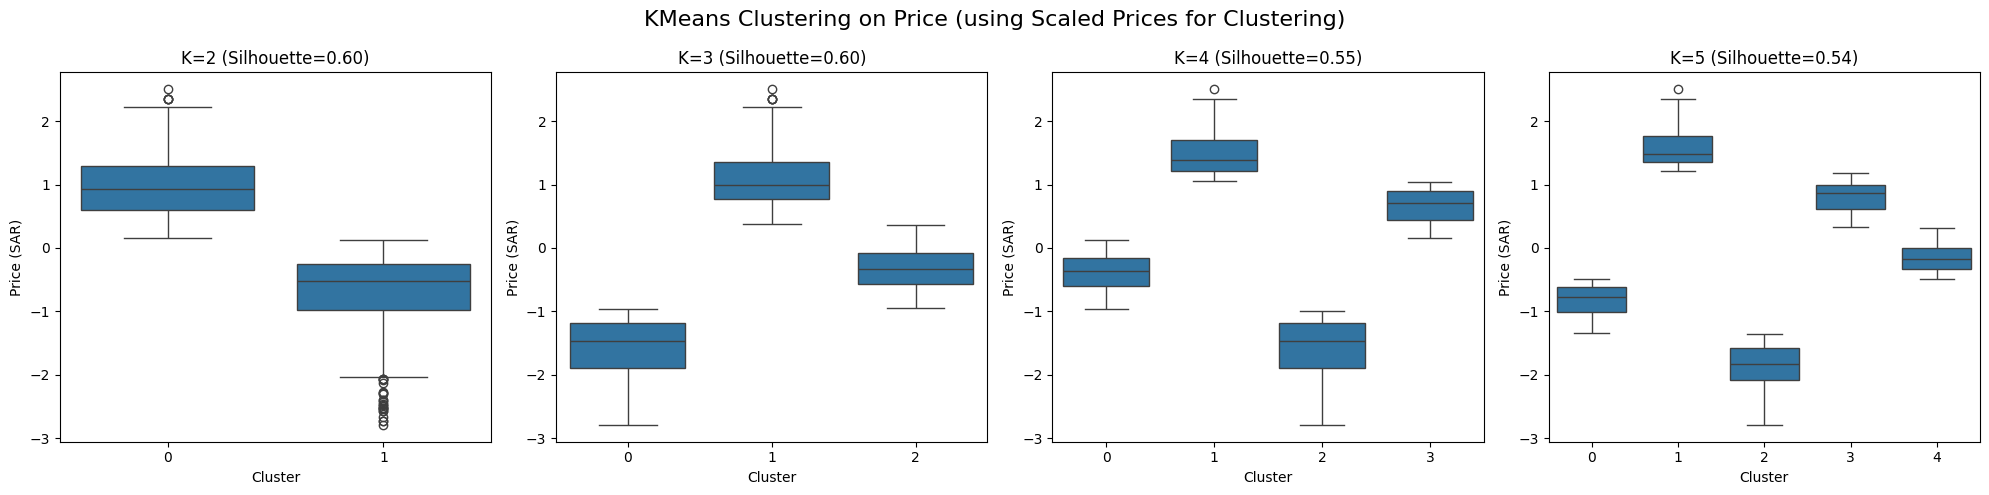

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


# 2. Feature for clustering
X_price = df_cleaned[["price_scaled"]].values

# 3. Plot setup
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# 4. Try multiple cluster counts
for idx, k in enumerate([2, 3, 4, 5]):
    if len(df_cleaned) < k:
        print(f"Skipping k={k} due to insufficient data.")
        continue

    # Fit KMeans
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(X_price)

    # Add cluster labels to DataFrame
    cluster_col = f"cluster_k{k}"
    df_cleaned[cluster_col] = kmeans.labels_

    # Silhouette score
    if len(set(kmeans.labels_)) > 1:
        sil_score = silhouette_score(X_price, kmeans.labels_)
    else:
        sil_score = np.nan

    # Boxplot using raw prices, grouped by cluster
    sns.boxplot(
        x=cluster_col,
        y="price_scaled",  # Show real prices
        data=df_cleaned,
        ax=axes[idx]
    )
    axes[idx].set_title(f"K={k} (Silhouette={sil_score:.2f})")
    axes[idx].set_xlabel("Cluster")
    axes[idx].set_ylabel("Price (SAR)")

# Final plot formatting
plt.suptitle("KMeans Clustering on Price (using Scaled Prices for Clustering)", fontsize=16)
plt.tight_layout()
plt.show()


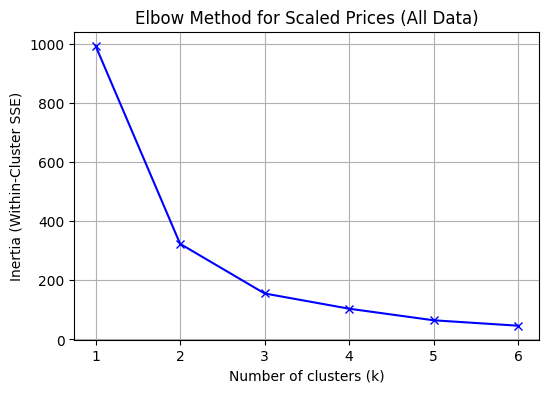

In [15]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Extract scaled price for clustering
X_price = df_cleaned[["price_scaled"]].values

# Elbow Method: Try k from 2 to 5
distortions = []
K_range = range(1, 7)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(X_price)
    distortions.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(6, 4))
plt.plot(K_range, distortions, 'bx-')
plt.title('Elbow Method for Scaled Prices (All Data)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-Cluster SSE)')
plt.xticks(K_range)
plt.grid(True)
plt.show()


In [16]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# 1. Extract price_scaled values for clustering
X_price = df_cleaned[["price_scaled"]].values

# 2. Run KMeans with k=3
k = 3
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(X_price)

# 3. Assign cluster labels back to df_cleaned
df_cleaned = df_cleaned.copy()  # optional: avoid modifying original
df_cleaned["final_cluster"] = kmeans.labels_

# 4. Show actual price statistics per cluster
summary = (
    df_cleaned
    .groupby("final_cluster")["Price"]
    .agg(["count", "mean", "min", "max"])
    .sort_index()
)

print("Cluster Summary Based on Actual Prices (SAR):")
print(summary)


Cluster Summary Based on Actual Prices (SAR):
               count        mean     min     max
final_cluster                                   
0                146   30.966370   11.30   46.93
1                362  229.976685  129.00  631.00
2                485   78.287216   47.38  128.10


In [18]:
low = df_cleaned[
    (df_cleaned["final_cluster"] == 0)
]
low

,Unnamed: 0,Website,Product type,Product Link,Product Img,Product Name,Price,volume,price_log,price_scaled,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
17,NaN,Noon,Foundation,https://www.noon.com/saudi-en/speedy-883-dark-...,https://f.nooncdn.com/p/v1551362048/N21504766A...,Bigen Speedy 883 Dark Brown Cream Kit,43.60,NaN,3.797734,-1.059389,1,0,2,0,0
19,NaN,Noon,Foundation,https://www.noon.com/saudi-en/bogenia-longwear...,https://f.nooncdn.com/p/pzsku/ZA77CB2462FE12F8...,Bogenia Bogenia Longwear Foundation ANGELIC Ca...,39.00,NaN,3.688879,-1.205803,1,0,2,0,0
20,NaN,Amazon,Foundation,https://www.amazon.sa/-/en/Bourjois-Healthy-Cl...,https://m.media-amazon.com/images/I/61e5yl5NUz...,Bourjois - Healthy Mix Clean Foundation - 50.5...,39.98,NaN,3.713084,-1.173246,1,0,2,0,0
43,NaN,Amazon,Foundation,https://www.amazon.sa/-/en/Bourjois-Healthy-Mi...,https://m.media-amazon.com/images/I/61MyudVAG5...,Bourjois Healthy Mix Clean Foundation - 53W - ...,38.28,30.0,3.670715,-1.230234,1,0,2,0,0
44,NaN,Amazon,Foundation,https://www.amazon.sa/-/en/Bourjois-Healthy-Mi...,https://m.media-amazon.com/images/I/61OeLmW2g+...,Bourjois Healthy Mix Clean Foundation - 55N - ...,39.98,30.0,3.713084,-1.173246,1,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965,NaN,Amazon,Foundation,https://www.amazon.sa/-/en/essence-Insta-Perfe...,https://m.media-amazon.com/images/I/61bCJYzIbo...,essence Insta Perfect Liquid Makeup 50,24.00,NaN,3.218876,-1.837976,1,0,2,2,0
966,NaN,Amazon,Foundation,https://www.amazon.sa/-/en/essence-Natural-Mat...,https://m.media-amazon.com/images/I/51UKDM18FY...,essence Natural Matte Mousse Foundation 01,20.01,NaN,3.044999,-2.071848,1,0,2,2,0
967,NaN,Amazon,Foundation,https://www.amazon.sa/-/en/essence-Natural-Mat...,https://m.media-amazon.com/images/I/71JWLVp+Me...,essence Natural Matte Mousse Foundation 04,13.95,NaN,2.704711,-2.529548,1,0,2,2,0
968,NaN,Amazon,Foundation,https://www.amazon.sa/-/en/essence-Natural-Mat...,https://m.media-amazon.com/images/I/71gjG4jpUn...,essence Natural Matte Mousse Foundation 13,13.95,NaN,2.704711,-2.529548,1,0,2,2,0


In [19]:
mid = df_cleaned[
    (df_cleaned["final_cluster"] == 2)
]
mid

,Unnamed: 0,Website,Product type,Product Link,Product Img,Product Name,Price,volume,price_log,price_scaled,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
0,NaN,Amazon,Foundation,https://www.amazon.sa/-/en/Bourjois-Healthy-Fa...,https://m.media-amazon.com/images/I/41spQAcxqD...,2 x Bourjois Healthy Mix Anti Fatigue Foundati...,52.99,30.0,3.988799,-0.802399,1,2,0,0,2
4,NaN,Noon,Foundation,https://www.noon.com/saudi-en/avon-power-stay-...,NaN,AVON AVON Power Stay 24 Hour Longwear Foundati...,65.00,NaN,4.189655,-0.532240,1,2,0,0,2
5,NaN,Noon,Foundation,https://www.noon.com/saudi-en/avon-power-stay-...,NaN,AVON AVON Power Stay 24 Hour Longwear Foundati...,65.00,NaN,4.189655,-0.532240,1,2,0,0,2
6,NaN,Noon,Foundation,https://www.noon.com/saudi-en/avon-power-stay-...,NaN,AVON AVON Power Stay 24 Hour Longwear Foundati...,65.00,NaN,4.189655,-0.532240,1,2,0,0,2
11,NaN,Amazon,Foundation,https://www.amazon.sa/-/en/BOURJOIS-PARIS-Face...,https://m.media-amazon.com/images/I/51A-IBmJSY...,BOURJOIS PARIS Air Mat 24H Face Foundation- 3 ...,69.00,30.0,4.248495,-0.453097,1,2,0,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984,NaN,Noon,Foundation,https://www.noon.com/saudi-en/smooth-skin-fdt-...,NaN,flormar Smooth Skin Fdt-007 Golden Neutral,55.00,NaN,4.025352,-0.753234,1,2,0,0,2
986,NaN,Noon,Foundation,https://www.noon.com/saudi-en/x-ceptional-wear...,NaN,gosh X-Ceptional Wear Foundation 16 Golden,66.75,NaN,4.215824,-0.497041,1,2,0,0,2
987,NaN,Noon,Foundation,https://www.noon.com/saudi-en/x-ceptional-wear...,https://f.nooncdn.com/p/v1663073051/N31918541A...,gosh X-Ceptional Wear Foundation 18 Sunny,66.75,NaN,4.215824,-0.497041,1,2,0,0,2
989,NaN,Noon,Foundation,https://www.noon.com/saudi-en/oil-control-full...,NaN,matt look Oil Control Full Coverage Matte Foun...,104.00,NaN,4.653960,0.092269,1,2,0,4,2


In [20]:
high = df_cleaned[
    (df_cleaned["final_cluster"] == 1)
]
high

,Unnamed: 0,Website,Product type,Product Link,Product Img,Product Name,Price,volume,price_log,price_scaled,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
1,NaN,Amazon,Foundation,https://www.amazon.sa/-/en/Max-Factor-Performa...,https://m.media-amazon.com/images/I/71fEw14ITq...,3 x Max Factor Lasting Performance Weightless ...,232.24,NaN,5.452068,1.165756,0,1,1,3,1
2,NaN,Sephora,Foundation,https://www.sephora.me/sa-en/p/impeccable-blur...,https://img-product.sephora.me/dw/image/v2/BKW...,ANASTASIA BEVERLY HILLS Impeccable Blurring Se...,240.00,NaN,5.484797,1.209777,0,1,1,1,1
3,NaN,Sephora,Foundation,https://www.sephora.me/sa-en/p/luminous-founda...,https://img-product.sephora.me/dw/image/v2/BKW...,ANASTASIA BEVERLY HILLS Luminous Foundation,220.00,NaN,5.398163,1.093251,0,1,1,3,1
7,NaN,Noon,Foundation,https://www.noon.com/saudi-en/skin-love-weight...,NaN,BECCA Skin Love Weightless Blur Foundation Cas...,259.00,NaN,5.560682,1.311845,0,1,1,1,1
8,NaN,Noon,Foundation,https://www.noon.com/saudi-en/skin-love-weight...,https://f.nooncdn.com/p/v1571490985/N30991568A...,BECCA Skin Love Weightless Blur Liquid Foundat...,271.00,NaN,5.605802,1.372534,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,NaN,Noon,Foundation,https://www.noon.com/saudi-en/real-flawless-we...,NaN,laura mercier Real Flawless Weightless Perfect...,355.00,30.0,5.874931,1.734523,0,1,1,1,1
990,NaN,Amazon,Foundation,https://www.amazon.sa/-/en/tarte-Amazonian-16-...,https://m.media-amazon.com/images/I/61Lrgy-Pgx...,tarte Amazonian clay 16-hour full coverage fou...,204.78,NaN,5.326808,0.997276,0,1,3,3,1
991,NaN,Amazon,Foundation,https://www.amazon.sa/-/en/tarte-Amazonian-16-...,https://m.media-amazon.com/images/I/61U8Z4u5rV...,tarte Amazonian clay 16-hour full coverage fou...,204.78,NaN,5.326808,0.997276,0,1,3,3,1
992,NaN,Amazon,Foundation,https://www.amazon.sa/-/en/tarte-Amazonian-16-...,https://m.media-amazon.com/images/I/61bxSWsoSm...,tarte Amazonian clay 16-hour full coverage fou...,204.78,NaN,5.326808,0.997276,0,1,3,3,1
